In [ ]:
# link to data set: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh/about_data

In [1]:
# the bare minimum
import matplotlib.pyplot as plt  # for plotting
import geopandas as gpd  # for geospatial data handling
from matplotlib.lines import Line2D

# more advanced
from lonboard._map import Map
from lonboard._layer import PolygonLayer  # for mapping in 3D
from lonboard.colormap import (
    apply_categorical_cmap,
    apply_continuous_cmap,
)  # for assigning colors
from palettable.colorbrewer.sequential import PuRd_9  # for color palettes
from matplotlib.colors import LogNorm  # for logarithmic normalization
import pygwalker as pyg  # for creating interactive data visualizations

In [2]:
import pandas as pd

# Full path to the Excel file
file_path = (
    "/Users/mikayassur/Downloads/2015_Street_Tree_Census_-_Tree_Data_20250710.csv"
)

# Read the Excel file
df = pd.read_csv(file_path)

# Display the first 5 rows
print(df.head())

   tree_id  block_id  created_at  tree_dbh  stump_diam curb_loc status health  \
0   180683    348711  08/27/2015         3           0   OnCurb  Alive   Fair   
1   200540    315986  09/03/2015        21           0   OnCurb  Alive   Fair   
2   204026    218365  09/05/2015         3           0   OnCurb  Alive   Good   
3   204337    217969  09/05/2015        10           0   OnCurb  Alive   Good   
4   189565    223043  08/30/2015        21           0   OnCurb  Alive   Good   

                            spc_latin       spc_common  ...  boro_ct  \
0                         Acer rubrum        red maple  ...  4073900   
1                   Quercus palustris          pin oak  ...  4097300   
2  Gleditsia triacanthos var. inermis      honeylocust  ...  3044900   
3  Gleditsia triacanthos var. inermis      honeylocust  ...  3044900   
4                     Tilia americana  American linden  ...  3016500   

      state   latitude  longitude         x_sp         y_sp council district  \


In [3]:
print("Columns:\n", df.columns)

Columns:
 Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')


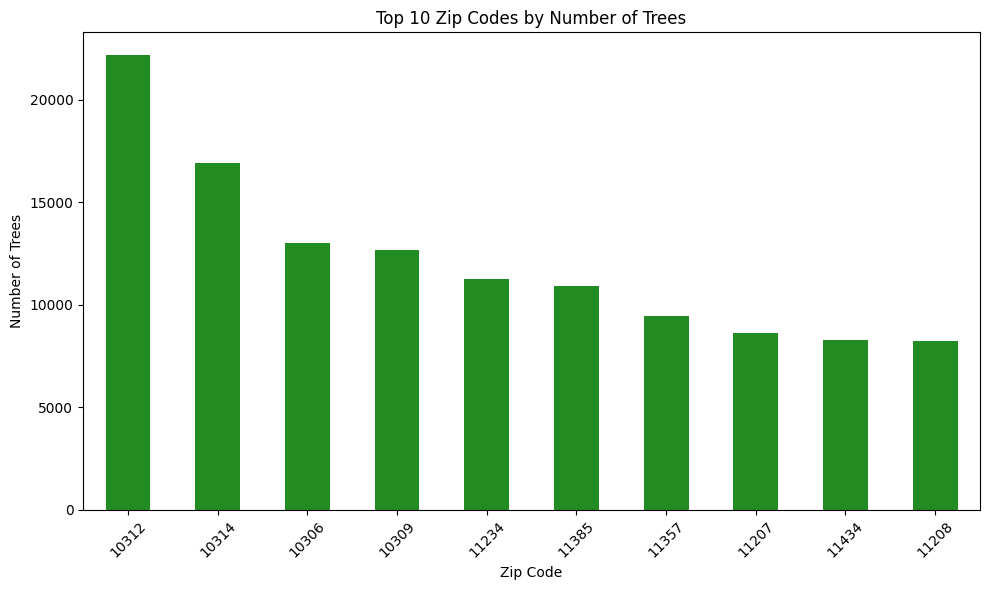

In [5]:
import matplotlib.pyplot as plt

# Count trees per zip code
tree_counts = df["postcode"].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
tree_counts.plot(kind="bar", color="forestgreen")
plt.title("Top 10 Zip Codes by Number of Trees")
plt.xlabel("Zip Code")
plt.ylabel("Number of Trees")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# I noticed the top four zip codes with the most trees are in Staten Island, before Kings County (Brooklyn), and then Ridgewood (my neighborhood! in Queens).

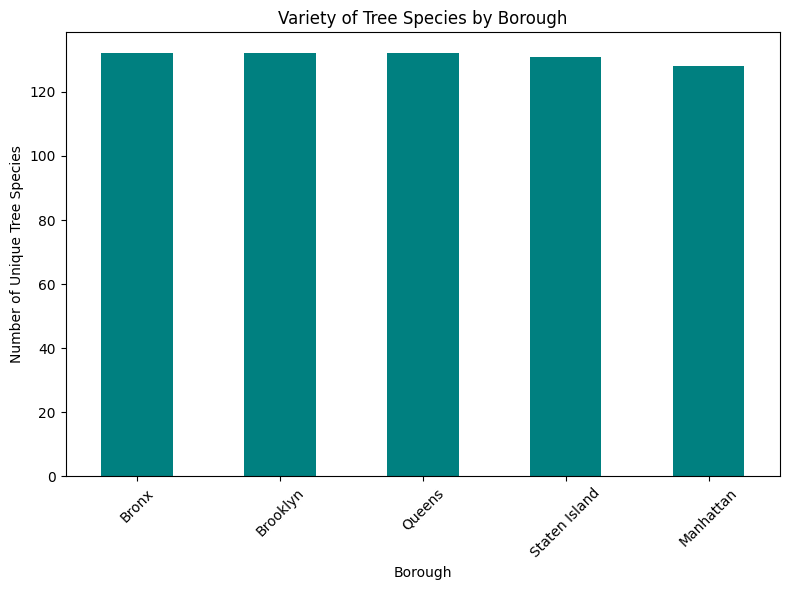

In [ ]:
# Counts the number of unique tree species in each borough, then sorts the boroughs so the one with the most variety of species appears first
species_by_borough = (
    df.groupby("borough")["spc_common"].nunique().sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(8, 6))
species_by_borough.plot(kind="bar", color="teal")
plt.title("Variety of Tree Species by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Unique Tree Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# I was curious to see if the variety of tree species varied by burough; it looks like it's fairly equal with Manhattan having slightly less variation. Because the numbers are so similar, this chart isn't clearly showing the number of tree species, so I'm going to print that below.

In [9]:
# Count unique species per borough
species_by_borough = (
    df.groupby("borough")["spc_common"].nunique().sort_values(ascending=False)
)

# Print the results nicely
print("Number of unique tree species per borough:\n")
for borough, count in species_by_borough.items():
    print(f"{borough}: {count}")

Number of unique tree species per borough:

Bronx: 132
Brooklyn: 132
Queens: 132
Staten Island: 131
Manhattan: 128


In [ ]:
# It's interesting that the Bronx, Brooklyn, and Queens all have *exactly* the same number of tree species, and wonder how that classificaiton system works / how that data are collected.

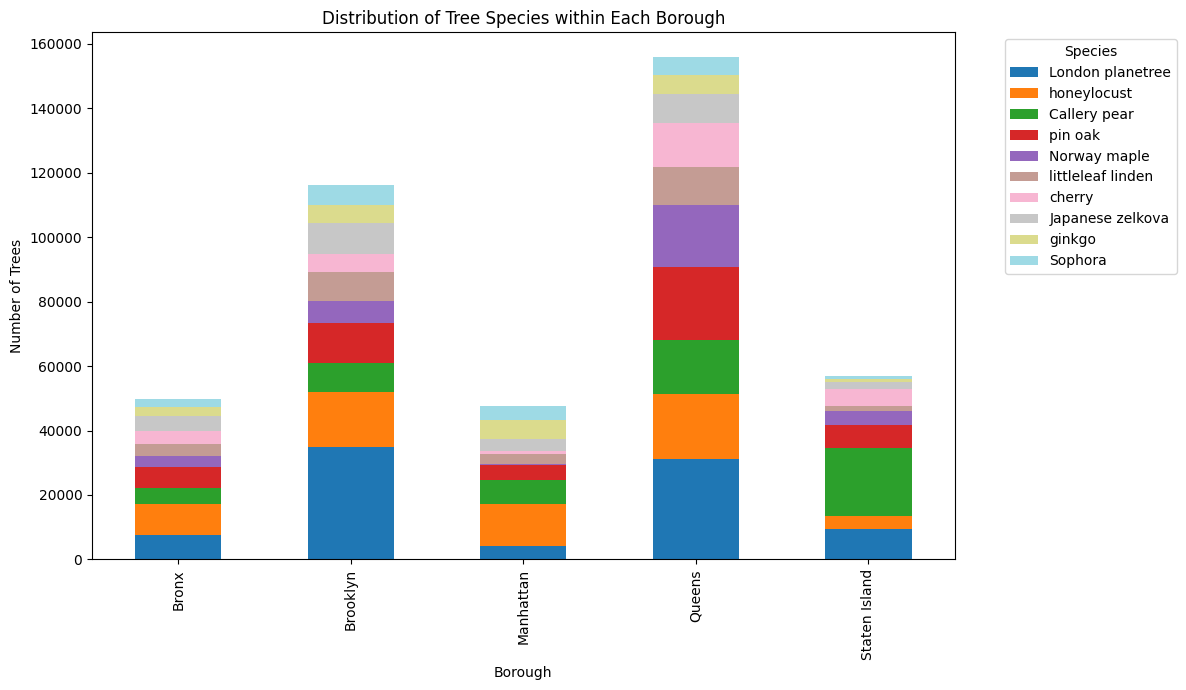

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Count trees per species within each borough
species_counts = df.groupby(["borough", "spc_common"]).size().unstack(fill_value=0)

# Optional: to avoid overcrowding, keep only top N species overall
top_species = df["spc_common"].value_counts().head(10).index
species_counts_top = species_counts[top_species]

# Plot stacked bar chart
species_counts_top.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="tab20")

plt.title("Distribution of Tree Species within Each Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Trees")
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# It's interesting to note that even though Staten Island contains the zip code with the most trees, Queens has the most trees overall.

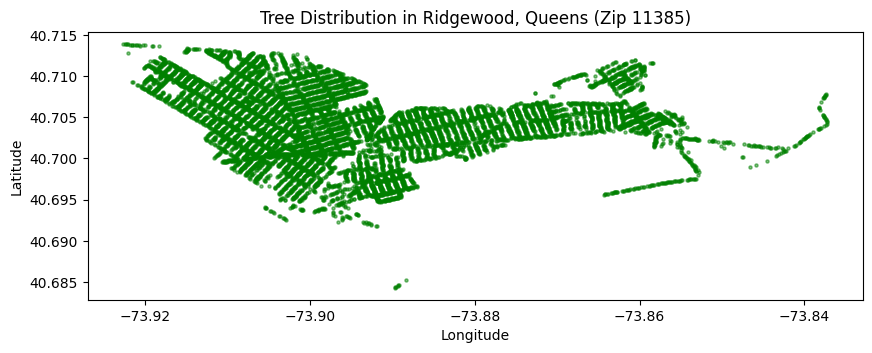

In [14]:
from shapely.geometry import Point

# Filter for zip code 11385
ridgewood = df[df["postcode"] == 11385]

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(ridgewood["longitude"], ridgewood["latitude"])]
gdf = gpd.GeoDataFrame(ridgewood, geometry=geometry)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, markersize=5, color="green", alpha=0.5)
plt.title("Tree Distribution in Ridgewood, Queens (Zip 11385)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

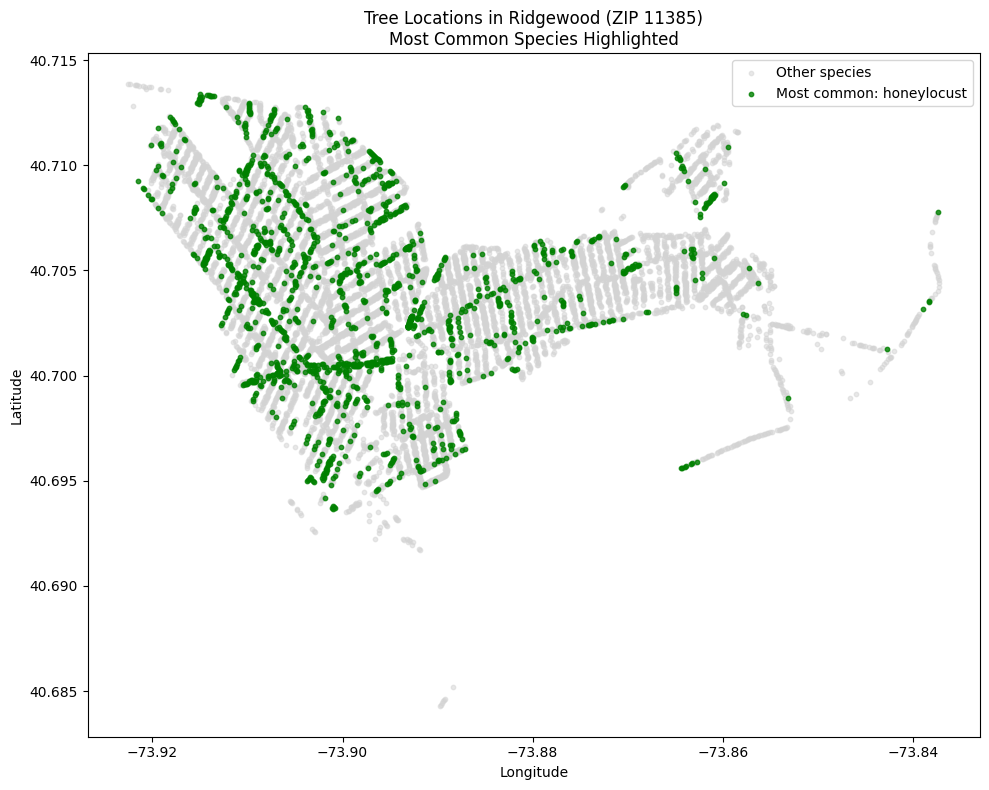

In [11]:
# Filter to Ridgewood
ridgewood = df[df["postcode"] == 11385].copy()

# Drop rows with missing lat/lon or species
ridgewood = ridgewood.dropna(subset=["latitude", "longitude", "spc_common"])

# Identify the most common species
most_common_species = ridgewood["spc_common"].value_counts().idxmax()

# Add a column to tag whether each tree is the most common species
ridgewood["is_most_common"] = ridgewood["spc_common"] == most_common_species

# Plot
plt.figure(figsize=(10, 8))

# Plot all other species in light gray
plt.scatter(
    ridgewood[~ridgewood["is_most_common"]]["longitude"],
    ridgewood[~ridgewood["is_most_common"]]["latitude"],
    s=10,
    c="lightgray",
    label="Other species",
    alpha=0.5,
)

# Plot most common species in green
plt.scatter(
    ridgewood[ridgewood["is_most_common"]]["longitude"],
    ridgewood[ridgewood["is_most_common"]]["latitude"],
    s=10,
    c="green",
    label=f"Most common: {most_common_species}",
    alpha=0.8,
)

plt.title("Tree Locations in Ridgewood (ZIP 11385)\nMost Common Species Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

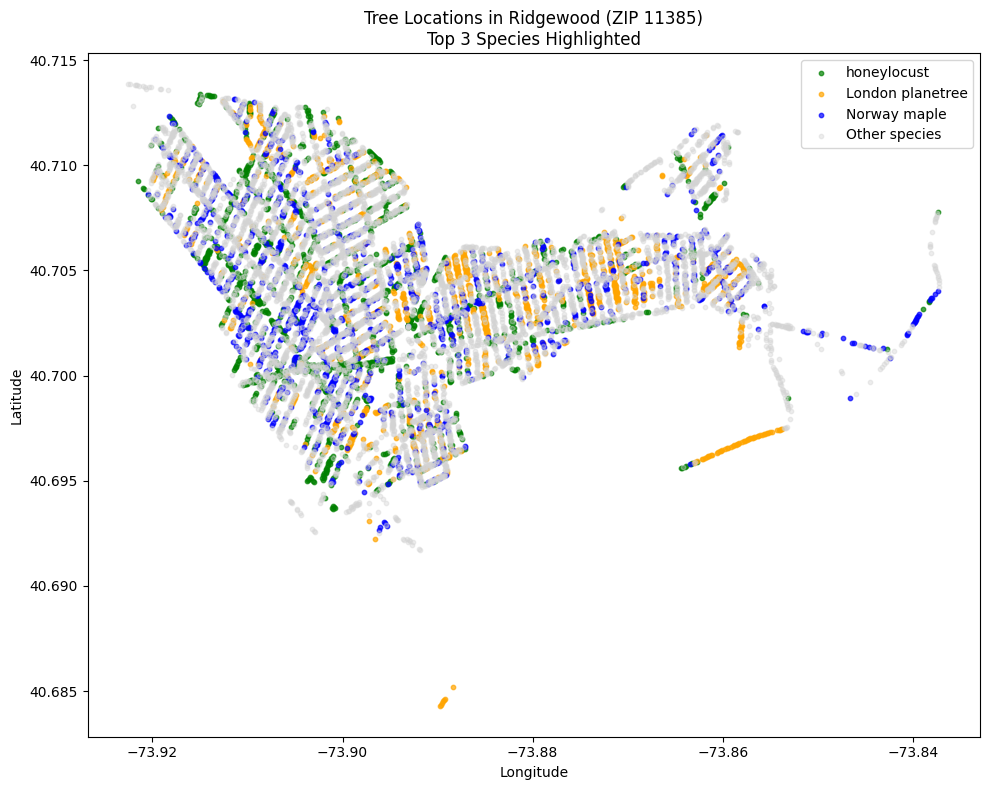

In [ ]:
# Find the top 3 most common species
top_species = ridgewood["spc_common"].value_counts().head(3).index.tolist()

# Define colors for the top 3 species
colors = ["green", "orange", "blue"]
species_color_map = dict(zip(top_species, colors))

# Assign a color to each row
ridgewood["color"] = ridgewood["spc_common"].apply(
    lambda x: species_color_map.get(x, "lightgray")  # default to gray for others
)

# Plot
plt.figure(figsize=(10, 8))

for species in top_species:
    species_data = ridgewood[ridgewood["spc_common"] == species]
    plt.scatter(
        species_data["longitude"],
        species_data["latitude"],
        s=10,
        color=species_color_map[species],
        label=species,
        alpha=0.7,
    )

# Plot all other species in gray
other_data = ridgewood[~ridgewood["spc_common"].isin(top_species)]
plt.scatter(
    other_data["longitude"],
    other_data["latitude"],
    s=10,
    color="lightgray",
    label="Other species",
    alpha=0.4,
)

plt.title("Tree Locations in Ridgewood (ZIP 11385)\nTop 3 Species Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Get top 3 species
top_species_counts = ridgewood["spc_common"].value_counts().head(3)

# Print the results
print("Top 3 Most Common Tree Species in Ridgewood (ZIP 11385):\n")
for species, count in top_species_counts.items():
    print(f"{species}: {count} trees")

Top 3 Most Common Tree Species in Ridgewood (ZIP 11385):

honeylocust: 1502 trees
London planetree: 1290 trees
Norway maple: 1235 trees
